This worksheet is to utilize different combinations of data manipulation with the simple random forest model to find the best data combination. 

# Data Preprocessing

In [1]:
from fastai.imports import *

In [2]:
'''import pandas as pd
import numpy as np
import base64
import os
import random
import gc'''

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)   

from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

Possible models to use: DecisionTreeClassifier, RFClassifier, XGBClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, CatBoosting, Neural Network. 

Per the Jason Brownlee article stacking is best with distinct model types that have uncorrelated predictions, or errors in predictions. Therefore, it seems the more different the models, the better. He uses these models in his example: Logistic Regression, k-Nearest Neighbors, Decision Tree, Support Vector Machine, Naive Bayes.

Maybe I should look at RFClassifer, XBGClassifier, CatBoosting, Nueral Network, LightGBM. 

In [39]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

To separate the PassengerId out to be used for the Kaggle submission later, since it will be taken out of the test dataset. 

In [40]:
passengerid = pd.DataFrame(test['PassengerId'])

In [41]:
passengerid.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


To combine the train and test datasets into one dataset for prepocessing work. 

In [42]:
train_test = pd.concat([train, test])

To set all expenses to 0 if someone is in cryosleep, since they can't spend money then. 

In [43]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

In [44]:
train_test.loc[:,Expenses_columns]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

To create a new Expenses category that sums up all the other expenses. 

In [45]:
train_test['Expenses'] = train_test.loc[:,Expenses_columns].sum(axis=1)

For any expenses that are NaN and where cryosleep is true, those missing values will be made equal to zero. This appeared to eliminate all NaNs from expenses.

In [46]:
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [47]:
train_test.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        174
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      170
FoodCourt        180
ShoppingMall     175
Spa              177
VRDeck           177
Name             294
Transported     4277
Expenses           0
dtype: int64

This creates a new Group category which is simply the first four numbers of the PassengerID values. 

In [48]:
train_test.loc[:,['Group']] = train_test.PassengerId.apply(lambda x: x[0:4] )

To break out the 3 values in Cabin each into a new column. 

In [49]:
train_test[['Deck', 'Number', 'Side']] = train_test['Cabin'].str.split('/', expand=True)

To break out Name into FirstName and SecondName columns. 

In [50]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['SecondName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]

To create a Name_key column by combining the SecondName and Room values. I'm not sure why this was done. 

In [51]:
train_test['Name_key']=train_test['SecondName']+train_test['Group']

To identify the numeric and categorical columns that will be used for further processing. 

In [52]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Deck','Number','Side','VIP','HomePlanet','Destination','Name_key','Group','Name','Cabin']
transported=['Transported']

In [53]:
passengerid = pd.DataFrame(test['PassengerId'])

In [54]:
passengerid.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


To create a new train_test dataset with only the columns identified above. 

In [55]:
train_test = train_test[num_cols+cat_cols+transported].copy()

To use the modes of each column as the basis for filling in all NaN values. 

In [56]:
modes = train_test[num_cols+cat_cols].mode().iloc[0]
modes

ShoppingMall               0.0
FoodCourt                  0.0
RoomService                0.0
Spa                        0.0
VRDeck                     0.0
Expenses                   0.0
Age                       18.0
CryoSleep                False
Deck                         F
Number                      82
Side                         S
VIP                      False
HomePlanet               Earth
Destination        TRAPPIST-1e
Name_key         Bonnondry8956
Group                     0339
Name            Alasmon Meteet
Cabin                  G/160/P
Name: 0, dtype: object

In [57]:
train_test.fillna(modes, inplace=True)

In [58]:
train_test.isna().sum()

ShoppingMall       0
FoodCourt          0
RoomService        0
Spa                0
VRDeck             0
Expenses           0
Age                0
CryoSleep          0
Deck               0
Number             0
Side               0
VIP                0
HomePlanet         0
Destination        0
Name_key           0
Group              0
Name               0
Cabin              0
Transported     4277
dtype: int64

To convert the categorical data to numbers.

In [59]:
for column in cat_cols:
     train_test[column] = pd.factorize(train_test[column])[0]

To recreate the train dataset by pulling in all the rows in train_test that include Transported values. 

In [60]:
train = train_test[train_test['Transported'].notnull()].copy()

To convert the boolean values of Transported into integers; go from True/False to 0/1. 

In [61]:
train.Transported =train.Transported.astype('int')

To recreate the test dataset by pulling all the rows in train_test where Transported have no values, and then drop the Transported column.

In [62]:
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

To identify the independent and dependent variables. 

In [63]:
X = train.drop('Transported',axis=1)
y = train.Transported

In [64]:
test.head()

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,CryoSleep,Deck,Number,Side,VIP,HomePlanet,Destination,Name_key,Group,Name,Cabin
0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,1,3,3,1,0,1,0,6387,6217,8473,6561
1,0.0,9.0,0.0,2823.0,0.0,2832.0,19.0,0,1,5,1,0,1,0,6388,6218,8474,6562
2,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1,6,0,1,0,0,2,6389,6219,8475,6563
3,0.0,6652.0,0.0,181.0,585.0,7418.0,38.0,0,6,1,1,0,0,0,6390,6220,8476,6564
4,635.0,0.0,10.0,0.0,0.0,645.0,20.0,0,1,6,1,0,1,0,6391,6221,8477,6565


# Finding the Best Model Parameters

In [73]:
def xgb_objective(trial):
    #print("START__________________________________")
    param = {  
        'tree_method':method,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,3000),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
        #'early_stopping_rounds':200,
        }
    
    skf = StratifiedKFold(n_splits=4)
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = xgb.XGBClassifier(**param).fit(train_X,train_y,
                                      eval_set=[(valid_X,valid_y)],
                                      verbose=0
                                     )  
        #n_iteration = model.get_booster().best_iteration
        #n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        #i=int(sum(n_iterations)/len(n_iterations))
   # print("Average n_ite=" + str(i))
   # print("% of scatter =" + str(np.std(n_iterations)/i))    
    n=sum(results)/len(results) 
    #print (n)
    #print("FINISH__________________________________\n")
    return n

#if optuna_study == XGB_study:
#    study = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
#                                direction='maximize')
#    study.optimize(objective, n_trials=1000)'''

In [74]:
study_xgb = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                            direction='maximize')
study_xgb.optimize(xgb_objective, n_trials=1000)
print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

[I 2023-04-27 13:51:28,203] A new study created in memory with name: no-name-8770f719-4fb9-4d69-a05a-469fd5c1d48e
[W 2023-04-27 13:51:28,211] Trial 0 failed with parameters: {'lambda': 9.904633426280027, 'alpha': 7.405594170618953, 'colsample_bytree': 0.6935554941430837, 'subsample': 0.6020351414542655, 'learning_rate': 0.0420988060629436, 'n_estimators': 1422, 'max_depth': 8, 'min_child_weight': 2, 'num_parallel_tree': 1} because of the following error: TypeError("__init__() got an unexpected keyword argument 'tree_method'").
Traceback (most recent call last):
  File "C:\Users\tompe\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\tompe\AppData\Local\Temp\ipykernel_8144\424253557.py", line 25, in xgb_objective
    model = RandomForestClassifier(random_state=42, **param).fit(train_X,train_y,
TypeError: __init__() got an unexpected keyword argument 'tree_method'
[W 2023-04-27 13:51:28,212] Trial 0 failed w

TypeError: __init__() got an unexpected keyword argument 'tree_method'

Trial 259 finished with value: 0.7884537103559576 and parameters: {'lambda': 4.6495922094944815, 'alpha': 5.191270161684729, 'colsample_bytree': 0.8496346394023989, 'subsample': 0.3511186061166151, 'learning_rate': 0.00054960984841739, 'n_estimators': 1699, 'max_depth': 10, 'min_child_weight': 8, 'num_parallel_tree': 1}. Best is trial 259 with value: 0.7884537103559576.

Out of 679 trials

In [29]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=.25, random_state=42)

In [29]:
#Trial 259 finished with value: 0.7884537103559576
params_XGB_best= {'lambda': 4.6495922094944815, 
             'alpha': 5.191270161684729, 
             'colsample_bytree': 0.8496346394023989, 
             'subsample': 0.3511186061166151, 
             'learning_rate': 0.00054960984841739, 
             'n_estimators': 1699, #initial value is 651
             'max_depth': 10, 
             'min_child_weight': 8, 
             'num_parallel_tree': 1}
#679 trials

In [32]:
xgb_model = (xgb.XGBClassifier(**params_XGB_best).fit(X,y))
xgb_predictions = xgb_model.predict(X_test)
accuracy_score(y_test, xgb_predictions)

0.8017479300827967

In [79]:
def rf_objective(trial):
    #print("START__________________________________")
    param = {  
        
        'n_estimators': trial.suggest_int ('n_estimators', 10, 500), 
        'max_depth': trial.suggest_int ('max_depth', 2, 64),
        'min_samples_leaf': trial.suggest_int ('min_samples_leaf', 1, 20),
        'min_samples_split': trial.suggest_int ('min_samples_split', 2, 18),
        'max_features': trial.suggest_categorical ('max_features', ['log2', 'sqrt', None]),
        'criterion' : trial.suggest_categorical ('criterion', ['gini', 'entropy'])
        
        }
    
    skf = StratifiedKFold(n_splits=4)
    results=[]
    n_iterations=[]
    for train_index, test_index in skf.split(X, y):
        train_X, valid_X = X.iloc[train_index], X.iloc[test_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[test_index]
        model = RandomForestClassifier(**param).fit(train_X,train_y)
                                 
        #n_iteration = model.get_booster().best_iteration
        #n_iterations.append(n_iteration)
        result = accuracy_score(valid_y,(model.predict(valid_X)))
        results.append(result)
        #i=int(sum(n_iterations)/len(n_iterations))
   # print("Average n_ite=" + str(i))
   # print("% of scatter =" + str(np.std(n_iterations)/i))    
    n=sum(results)/len(results) 
    #print (n)
    #print("FINISH__________________________________\n")
    return n


In [80]:
study_rf = optuna.create_study(pruner=optuna.pruners.HyperbandPruner(),
                            direction='maximize')
study_rf.optimize(rf_objective, n_trials=1000)
print('Number of finished trials:', len(study_rf.trials))
print('Best trial:', study_rf.best_trial.params)

[I 2023-04-27 13:59:33,707] A new study created in memory with name: no-name-28d199cd-622a-44b1-be25-fe767f626f11
[I 2023-04-27 13:59:34,212] Trial 0 finished with value: 0.7326725269691468 and parameters: {'n_estimators': 19, 'max_depth': 32, 'min_samples_leaf': 20, 'min_samples_split': 8, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.7326725269691468.
[I 2023-04-27 13:59:44,354] Trial 1 finished with value: 0.7455573038008071 and parameters: {'n_estimators': 434, 'max_depth': 35, 'min_samples_leaf': 20, 'min_samples_split': 17, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.7455573038008071.
[I 2023-04-27 13:59:47,523] Trial 2 finished with value: 0.7018468801054676 and parameters: {'n_estimators': 117, 'max_depth': 37, 'min_samples_leaf': 6, 'min_samples_split': 17, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.7455573038008071.
[I 2023-04-27 14:00:12,604] Trial 3 finished with value: 0.76682880

[I 2023-04-27 14:06:13,626] Trial 29 finished with value: 0.7812081005024869 and parameters: {'n_estimators': 80, 'max_depth': 32, 'min_samples_leaf': 19, 'min_samples_split': 8, 'max_features': None, 'criterion': 'entropy'}. Best is trial 29 with value: 0.7812081005024869.
[I 2023-04-27 14:06:15,842] Trial 30 finished with value: 0.7523382750838148 and parameters: {'n_estimators': 65, 'max_depth': 31, 'min_samples_leaf': 19, 'min_samples_split': 8, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 29 with value: 0.7812081005024869.
[I 2023-04-27 14:06:25,637] Trial 31 finished with value: 0.779022182416891 and parameters: {'n_estimators': 91, 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 8, 'max_features': None, 'criterion': 'entropy'}. Best is trial 29 with value: 0.7812081005024869.
[I 2023-04-27 14:06:36,098] Trial 32 finished with value: 0.7810929463419715 and parameters: {'n_estimators': 83, 'max_depth': 41, 'min_samples_leaf': 20, 'min_samples_split':

[I 2023-04-27 14:10:40,131] Trial 58 finished with value: 0.7815532454633706 and parameters: {'n_estimators': 23, 'max_depth': 51, 'min_samples_leaf': 16, 'min_samples_split': 9, 'max_features': None, 'criterion': 'gini'}. Best is trial 58 with value: 0.7815532454633706.
[I 2023-04-27 14:10:45,525] Trial 59 finished with value: 0.773730065523564 and parameters: {'n_estimators': 60, 'max_depth': 51, 'min_samples_leaf': 16, 'min_samples_split': 9, 'max_features': None, 'criterion': 'gini'}. Best is trial 58 with value: 0.7815532454633706.
[I 2023-04-27 14:10:46,957] Trial 60 finished with value: 0.7776417084135778 and parameters: {'n_estimators': 15, 'max_depth': 34, 'min_samples_leaf': 14, 'min_samples_split': 9, 'max_features': None, 'criterion': 'gini'}. Best is trial 58 with value: 0.7815532454633706.
[I 2023-04-27 14:10:49,665] Trial 61 finished with value: 0.7764908547698589 and parameters: {'n_estimators': 28, 'max_depth': 57, 'min_samples_leaf': 18, 'min_samples_split': 11, 'max_

[I 2023-04-27 14:14:08,559] Trial 87 finished with value: 0.7767213747713322 and parameters: {'n_estimators': 45, 'max_depth': 17, 'min_samples_leaf': 20, 'min_samples_split': 4, 'max_features': None, 'criterion': 'entropy'}. Best is trial 58 with value: 0.7815532454633706.
[I 2023-04-27 14:14:16,909] Trial 88 finished with value: 0.7813228313021184 and parameters: {'n_estimators': 82, 'max_depth': 49, 'min_samples_leaf': 18, 'min_samples_split': 10, 'max_features': None, 'criterion': 'gini'}. Best is trial 58 with value: 0.7815532454633706.
[I 2023-04-27 14:14:26,408] Trial 89 finished with value: 0.7754554198872082 and parameters: {'n_estimators': 107, 'max_depth': 49, 'min_samples_leaf': 19, 'min_samples_split': 10, 'max_features': None, 'criterion': 'gini'}. Best is trial 58 with value: 0.7815532454633706.
[I 2023-04-27 14:14:44,458] Trial 90 finished with value: 0.7737301713637852 and parameters: {'n_estimators': 139, 'max_depth': 51, 'min_samples_leaf': 18, 'min_samples_split': 1

[I 2023-04-27 14:18:49,815] Trial 116 finished with value: 0.7777568096539829 and parameters: {'n_estimators': 155, 'max_depth': 39, 'min_samples_leaf': 19, 'min_samples_split': 5, 'max_features': None, 'criterion': 'entropy'}. Best is trial 115 with value: 0.7818981258237016.
[I 2023-04-27 14:19:04,305] Trial 117 finished with value: 0.7755705740477238 and parameters: {'n_estimators': 143, 'max_depth': 32, 'min_samples_leaf': 17, 'min_samples_split': 6, 'max_features': None, 'criterion': 'gini'}. Best is trial 115 with value: 0.7818981258237016.
[I 2023-04-27 14:19:07,266] Trial 118 finished with value: 0.7372744597809276 and parameters: {'n_estimators': 103, 'max_depth': 41, 'min_samples_leaf': 18, 'min_samples_split': 5, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 115 with value: 0.7818981258237016.
[I 2023-04-27 14:19:17,572] Trial 119 finished with value: 0.7792519086167065 and parameters: {'n_estimators': 116, 'max_depth': 38, 'min_samples_leaf': 19, 'min_samples_

[I 2023-04-27 14:26:26,282] Trial 145 finished with value: 0.7804028151805359 and parameters: {'n_estimators': 413, 'max_depth': 45, 'min_samples_leaf': 20, 'min_samples_split': 17, 'max_features': None, 'criterion': 'entropy'}. Best is trial 115 with value: 0.7818981258237016.
[I 2023-04-27 14:26:58,332] Trial 146 finished with value: 0.7797124723386581 and parameters: {'n_estimators': 355, 'max_depth': 40, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 115 with value: 0.7818981258237016.
[I 2023-04-27 14:27:01,010] Trial 147 finished with value: 0.7409550534683629 and parameters: {'n_estimators': 75, 'max_depth': 38, 'min_samples_leaf': 19, 'min_samples_split': 2, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 115 with value: 0.7818981258237016.
[I 2023-04-27 14:27:24,104] Trial 148 finished with value: 0.7800574056190996 and parameters: {'n_estimators': 241, 'max_depth': 49, 'min_samples_leaf': 20, 'min_sampl

[I 2023-04-27 14:31:02,097] Trial 174 finished with value: 0.7791368602964119 and parameters: {'n_estimators': 96, 'max_depth': 29, 'min_samples_leaf': 18, 'min_samples_split': 9, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:31:09,508] Trial 175 finished with value: 0.7786767199353444 and parameters: {'n_estimators': 83, 'max_depth': 34, 'min_samples_leaf': 20, 'min_samples_split': 9, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:31:10,614] Trial 176 finished with value: 0.7309530996578821 and parameters: {'n_estimators': 32, 'max_depth': 32, 'min_samples_leaf': 19, 'min_samples_split': 8, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:31:20,273] Trial 177 finished with value: 0.7797127898593215 and parameters: {'n_estimators': 64, 'max_depth': 30, 'min_samples_leaf': 20, 'min_samples_split': 7,

[I 2023-04-27 14:34:35,868] Trial 203 finished with value: 0.7817831304235175 and parameters: {'n_estimators': 110, 'max_depth': 38, 'min_samples_leaf': 19, 'min_samples_split': 8, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:34:46,358] Trial 204 finished with value: 0.7804026035000938 and parameters: {'n_estimators': 119, 'max_depth': 38, 'min_samples_leaf': 20, 'min_samples_split': 8, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:34:56,915] Trial 205 finished with value: 0.7762613402504858 and parameters: {'n_estimators': 109, 'max_depth': 39, 'min_samples_leaf': 16, 'min_samples_split': 8, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:35:10,522] Trial 206 finished with value: 0.7801722951790626 and parameters: {'n_estimators': 147, 'max_depth': 36, 'min_samples_leaf': 19, 'min_samples_split': 

[I 2023-04-27 14:38:10,040] Trial 232 finished with value: 0.7800574585392102 and parameters: {'n_estimators': 43, 'max_depth': 54, 'min_samples_leaf': 18, 'min_samples_split': 7, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:38:12,857] Trial 233 finished with value: 0.7754553140469872 and parameters: {'n_estimators': 31, 'max_depth': 49, 'min_samples_leaf': 19, 'min_samples_split': 5, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:38:21,944] Trial 234 finished with value: 0.7801723480991731 and parameters: {'n_estimators': 100, 'max_depth': 47, 'min_samples_leaf': 19, 'min_samples_split': 6, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:38:29,351] Trial 235 finished with value: 0.7798275735790633 and parameters: {'n_estimators': 79, 'max_depth': 52, 'min_samples_leaf': 17, 'min_samples_split': 7, 

[I 2023-04-27 14:43:42,266] Trial 261 finished with value: 0.6772254282401184 and parameters: {'n_estimators': 112, 'max_depth': 37, 'min_samples_leaf': 1, 'min_samples_split': 8, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:43:53,773] Trial 262 finished with value: 0.7804024447397622 and parameters: {'n_estimators': 126, 'max_depth': 38, 'min_samples_leaf': 20, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 166 with value: 0.782818353625726.
[I 2023-04-27 14:44:24,938] Trial 263 finished with value: 0.7830474977043256 and parameters: {'n_estimators': 437, 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 9, 'max_features': None, 'criterion': 'gini'}. Best is trial 263 with value: 0.7830474977043256.
[I 2023-04-27 14:44:31,240] Trial 264 finished with value: 0.7801725597796153 and parameters: {'n_estimators': 67, 'max_depth': 18, 'min_samples_leaf': 20, 'min_samples_split': 9,

[I 2023-04-27 14:57:10,940] Trial 290 finished with value: 0.7820124332624486 and parameters: {'n_estimators': 374, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 288 with value: 0.7833926426652091.
[I 2023-04-27 14:57:38,384] Trial 291 finished with value: 0.7818972261818224 and parameters: {'n_estimators': 383, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 288 with value: 0.7833926426652091.
[I 2023-04-27 14:58:04,363] Trial 292 finished with value: 0.7833926426652091 and parameters: {'n_estimators': 381, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 288 with value: 0.7833926426652091.
[I 2023-04-27 14:58:29,930] Trial 293 finished with value: 0.7835076380653931 and parameters: {'n_estimators': 387, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 3

[I 2023-04-27 15:09:17,234] Trial 319 finished with value: 0.7804025505799832 and parameters: {'n_estimators': 389, 'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 4, 'max_features': None, 'criterion': 'gini'}. Best is trial 293 with value: 0.7835076380653931.
[I 2023-04-27 15:09:43,946] Trial 320 finished with value: 0.7828174010637365 and parameters: {'n_estimators': 375, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 293 with value: 0.7835076380653931.
[I 2023-04-27 15:10:04,052] Trial 321 finished with value: 0.771658137356052 and parameters: {'n_estimators': 374, 'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 293 with value: 0.7835076380653931.
[I 2023-04-27 15:10:32,731] Trial 322 finished with value: 0.7805177576606094 and parameters: {'n_estimators': 362, 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 4,

[I 2023-04-27 15:21:19,189] Trial 348 finished with value: 0.7785607719731708 and parameters: {'n_estimators': 355, 'max_depth': 5, 'min_samples_leaf': 17, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 293 with value: 0.7835076380653931.
[I 2023-04-27 15:21:27,240] Trial 349 finished with value: 0.7431421887165011 and parameters: {'n_estimators': 362, 'max_depth': 7, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 293 with value: 0.7835076380653931.
[I 2023-04-27 15:22:02,637] Trial 350 finished with value: 0.7782168441748294 and parameters: {'n_estimators': 394, 'max_depth': 12, 'min_samples_leaf': 17, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 293 with value: 0.7835076380653931.
[I 2023-04-27 15:22:15,614] Trial 351 finished with value: 0.7665933123374559 and parameters: {'n_estimators': 337, 'max_depth': 3, 'min_samples_leaf': 14, 'min_samples_split'

[I 2023-04-27 15:32:35,456] Trial 377 finished with value: 0.7809776334211243 and parameters: {'n_estimators': 366, 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:32:42,790] Trial 378 finished with value: 0.7404956539888428 and parameters: {'n_estimators': 359, 'max_depth': 6, 'min_samples_leaf': 19, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:33:16,730] Trial 379 finished with value: 0.7806327530607934 and parameters: {'n_estimators': 375, 'max_depth': 9, 'min_samples_leaf': 19, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:33:27,408] Trial 380 finished with value: 0.7642925046918969 and parameters: {'n_estimators': 276, 'max_depth': 3, 'min_samples_leaf': 19, 'min_samples_split':

[I 2023-04-27 15:44:36,017] Trial 406 finished with value: 0.7812068304198343 and parameters: {'n_estimators': 392, 'max_depth': 6, 'min_samples_leaf': 19, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:44:58,352] Trial 407 finished with value: 0.7794809997751954 and parameters: {'n_estimators': 379, 'max_depth': 5, 'min_samples_leaf': 19, 'min_samples_split': 4, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:45:31,534] Trial 408 finished with value: 0.7792522790574802 and parameters: {'n_estimators': 369, 'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:46:02,426] Trial 409 finished with value: 0.7808626380209402 and parameters: {'n_estimators': 421, 'max_depth': 7, 'min_samples_leaf': 18, 'min_samples_split': 2

[I 2023-04-27 15:57:05,874] Trial 435 finished with value: 0.7755729025325871 and parameters: {'n_estimators': 347, 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:57:39,781] Trial 436 finished with value: 0.7792510618949379 and parameters: {'n_estimators': 359, 'max_depth': 5, 'min_samples_leaf': 17, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:58:42,877] Trial 437 finished with value: 0.7769513126515897 and parameters: {'n_estimators': 488, 'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 15:59:21,032] Trial 438 finished with value: 0.7804025505799832 and parameters: {'n_estimators': 316, 'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 3,

[I 2023-04-27 16:12:16,193] Trial 464 finished with value: 0.771083054514911 and parameters: {'n_estimators': 355, 'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:12:44,808] Trial 465 finished with value: 0.7801725068595047 and parameters: {'n_estimators': 333, 'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:13:10,320] Trial 466 finished with value: 0.7813227254618973 and parameters: {'n_estimators': 366, 'max_depth': 6, 'min_samples_leaf': 17, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:13:52,152] Trial 467 finished with value: 0.7754558432480925 and parameters: {'n_estimators': 307, 'max_depth': 59, 'min_samples_leaf': 15, 'min_samples_split': 1

[I 2023-04-27 16:23:46,351] Trial 493 finished with value: 0.771197944074874 and parameters: {'n_estimators': 358, 'max_depth': 4, 'min_samples_leaf': 17, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:24:15,031] Trial 494 finished with value: 0.7814379325425234 and parameters: {'n_estimators': 389, 'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:24:46,209] Trial 495 finished with value: 0.7774115059327678 and parameters: {'n_estimators': 374, 'max_depth': 9, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:25:12,712] Trial 496 finished with value: 0.7825874102633685 and parameters: {'n_estimators': 367, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 4,

[I 2023-04-27 16:35:14,225] Trial 522 finished with value: 0.7789056523335016 and parameters: {'n_estimators': 318, 'max_depth': 5, 'min_samples_leaf': 17, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:35:40,942] Trial 523 finished with value: 0.7806326472205722 and parameters: {'n_estimators': 364, 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:36:13,416] Trial 524 finished with value: 0.7767213747713323 and parameters: {'n_estimators': 393, 'max_depth': 9, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 353 with value: 0.7837378934663137.
[I 2023-04-27 16:36:50,092] Trial 525 finished with value: 0.7790219178163384 and parameters: {'n_estimators': 353, 'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 2

[I 2023-04-27 16:47:15,912] Trial 551 finished with value: 0.7737289542012429 and parameters: {'n_estimators': 295, 'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy'}. Best is trial 528 with value: 0.7837379463864242.
[I 2023-04-27 16:48:06,613] Trial 552 finished with value: 0.7799425689792473 and parameters: {'n_estimators': 386, 'max_depth': 56, 'min_samples_leaf': 18, 'min_samples_split': 4, 'max_features': None, 'criterion': 'entropy'}. Best is trial 528 with value: 0.7837379463864242.
[I 2023-04-27 16:48:54,886] Trial 553 finished with value: 0.7791372836572961 and parameters: {'n_estimators': 374, 'max_depth': 14, 'min_samples_leaf': 17, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy'}. Best is trial 528 with value: 0.7837379463864242.
[I 2023-04-27 16:49:11,958] Trial 554 finished with value: 0.7800572997788786 and parameters: {'n_estimators': 235, 'max_depth': 7, 'min_samples_leaf': 18, 'min_sample

[I 2023-04-27 16:59:17,256] Trial 580 finished with value: 0.7452125822008077 and parameters: {'n_estimators': 334, 'max_depth': 7, 'min_samples_leaf': 19, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 16:59:34,076] Trial 581 finished with value: 0.7652129970944742 and parameters: {'n_estimators': 389, 'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 7, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:00:01,872] Trial 582 finished with value: 0.7779853186912561 and parameters: {'n_estimators': 323, 'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:00:10,922] Trial 583 finished with value: 0.7438325844784893 and parameters: {'n_estimators': 382, 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_spli

[I 2023-04-27 17:10:36,223] Trial 609 finished with value: 0.779366057295122 and parameters: {'n_estimators': 451, 'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 6, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:10:50,115] Trial 610 finished with value: 0.7648674287727064 and parameters: {'n_estimators': 363, 'max_depth': 3, 'min_samples_leaf': 17, 'min_samples_split': 6, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:11:11,250] Trial 611 finished with value: 0.7825874102633685 and parameters: {'n_estimators': 313, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 5, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:11:41,960] Trial 612 finished with value: 0.7804024976598727 and parameters: {'n_estimators': 352, 'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 5,

[I 2023-04-27 17:22:42,228] Trial 638 finished with value: 0.777641126292362 and parameters: {'n_estimators': 384, 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:23:09,971] Trial 639 finished with value: 0.779252067377038 and parameters: {'n_estimators': 349, 'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 4, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:23:39,902] Trial 640 finished with value: 0.7805175989002777 and parameters: {'n_estimators': 394, 'max_depth': 7, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:24:04,612] Trial 641 finished with value: 0.771198155755316 and parameters: {'n_estimators': 366, 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 3, 'm

[I 2023-04-27 17:33:32,577] Trial 667 finished with value: 0.7825876219438106 and parameters: {'n_estimators': 356, 'max_depth': 6, 'min_samples_leaf': 13, 'min_samples_split': 15, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:33:50,185] Trial 668 finished with value: 0.7709680061946165 and parameters: {'n_estimators': 368, 'max_depth': 4, 'min_samples_leaf': 14, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:34:18,932] Trial 669 finished with value: 0.7768361584910741 and parameters: {'n_estimators': 344, 'max_depth': 9, 'min_samples_leaf': 16, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:34:30,792] Trial 670 finished with value: 0.7823584249451007 and parameters: {'n_estimators': 149, 'max_depth': 8, 'min_samples_leaf': 16, 'min_samples_split': 

[I 2023-04-27 17:44:42,322] Trial 696 finished with value: 0.744637128918893 and parameters: {'n_estimators': 362, 'max_depth': 9, 'min_samples_leaf': 18, 'min_samples_split': 7, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:45:08,103] Trial 697 finished with value: 0.7836225805454666 and parameters: {'n_estimators': 386, 'max_depth': 6, 'min_samples_leaf': 17, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:45:45,225] Trial 698 finished with value: 0.7785617774552709 and parameters: {'n_estimators': 398, 'max_depth': 17, 'min_samples_leaf': 17, 'min_samples_split': 5, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 17:46:25,362] Trial 699 finished with value: 0.7795970006574795 and parameters: {'n_estimators': 388, 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split':

[I 2023-04-27 18:02:12,784] Trial 725 finished with value: 0.7807478543011983 and parameters: {'n_estimators': 417, 'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 2, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:03:17,852] Trial 726 finished with value: 0.7801729831404995 and parameters: {'n_estimators': 399, 'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 12, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:04:07,974] Trial 727 finished with value: 0.7815529279427074 and parameters: {'n_estimators': 397, 'max_depth': 6, 'min_samples_leaf': 16, 'min_samples_split': 2, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:04:28,298] Trial 728 finished with value: 0.7404827414818732 and parameters: {'n_estimators': 383, 'max_depth': 2, 'min_samples_leaf': 18, 'min_samples

[I 2023-04-27 18:18:02,160] Trial 754 finished with value: 0.7839678842666817 and parameters: {'n_estimators': 161, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:18:19,787] Trial 755 finished with value: 0.7795960480954899 and parameters: {'n_estimators': 274, 'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:18:30,195] Trial 756 finished with value: 0.7440621519179731 and parameters: {'n_estimators': 403, 'max_depth': 7, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:18:52,353] Trial 757 finished with value: 0.7799424102189156 and parameters: {'n_estimators': 174, 'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split':

[I 2023-04-27 18:27:26,543] Trial 783 finished with value: 0.7395623549195169 and parameters: {'n_estimators': 440, 'max_depth': 2, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:27:48,662] Trial 784 finished with value: 0.7799410872161524 and parameters: {'n_estimators': 382, 'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 5, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:27:56,558] Trial 785 finished with value: 0.7423363741934446 and parameters: {'n_estimators': 399, 'max_depth': 6, 'min_samples_leaf': 19, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:28:20,671] Trial 786 finished with value: 0.7800574056190996 and parameters: {'n_estimators': 344, 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_spli

[I 2023-04-27 18:38:25,094] Trial 812 finished with value: 0.7785608248932813 and parameters: {'n_estimators': 372, 'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:38:58,319] Trial 813 finished with value: 0.7778717521340563 and parameters: {'n_estimators': 362, 'max_depth': 13, 'min_samples_leaf': 17, 'min_samples_split': 4, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:39:33,605] Trial 814 finished with value: 0.779712048977774 and parameters: {'n_estimators': 419, 'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:40:10,996] Trial 815 finished with value: 0.7805172813796146 and parameters: {'n_estimators': 390, 'max_depth': 6, 'min_samples_leaf': 17, 'min_samples_split': 2

[I 2023-04-27 18:50:45,682] Trial 841 finished with value: 0.7786757144532442 and parameters: {'n_estimators': 185, 'max_depth': 5, 'min_samples_leaf': 19, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:51:16,334] Trial 842 finished with value: 0.7800574056190996 and parameters: {'n_estimators': 422, 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:51:35,082] Trial 843 finished with value: 0.7716582431962731 and parameters: {'n_estimators': 392, 'max_depth': 4, 'min_samples_leaf': 16, 'min_samples_split': 4, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 18:51:44,067] Trial 844 finished with value: 0.742912092075912 and parameters: {'n_estimators': 369, 'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 2,

[I 2023-04-27 19:02:31,412] Trial 870 finished with value: 0.7649824770930009 and parameters: {'n_estimators': 374, 'max_depth': 3, 'min_samples_leaf': 15, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:02:58,398] Trial 871 finished with value: 0.7785607190530603 and parameters: {'n_estimators': 349, 'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 4, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:03:04,705] Trial 872 finished with value: 0.7437173773978633 and parameters: {'n_estimators': 298, 'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:03:38,830] Trial 873 finished with value: 0.7734998630427539 and parameters: {'n_estimators': 387, 'max_depth': 9, 'min_samples_leaf': 14, 'min_samples_spli

[I 2023-04-27 19:13:24,687] Trial 899 finished with value: 0.7585481325339716 and parameters: {'n_estimators': 414, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:13:54,175] Trial 900 finished with value: 0.782012380342338 and parameters: {'n_estimators': 424, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:14:14,329] Trial 901 finished with value: 0.7785617245351604 and parameters: {'n_estimators': 245, 'max_depth': 8, 'min_samples_leaf': 17, 'min_samples_split': 4, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:14:32,739] Trial 902 finished with value: 0.7717732915165676 and parameters: {'n_estimators': 376, 'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 3, 

[I 2023-04-27 19:25:41,796] Trial 928 finished with value: 0.7777566508936513 and parameters: {'n_estimators': 220, 'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 2, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:26:03,446] Trial 929 finished with value: 0.7830474447842151 and parameters: {'n_estimators': 232, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:26:21,241] Trial 930 finished with value: 0.7808625321807192 and parameters: {'n_estimators': 203, 'max_depth': 7, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:26:37,456] Trial 931 finished with value: 0.7792508502144958 and parameters: {'n_estimators': 250, 'max_depth': 5, 'min_samples_leaf': 11, 'min_samples_split'

[I 2023-04-27 19:33:00,326] Trial 957 finished with value: 0.7418764984329297 and parameters: {'n_estimators': 196, 'max_depth': 8, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:33:11,961] Trial 958 finished with value: 0.770508077513991 and parameters: {'n_estimators': 216, 'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:33:26,703] Trial 959 finished with value: 0.7821275874229642 and parameters: {'n_estimators': 196, 'max_depth': 6, 'min_samples_leaf': 19, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:33:33,527] Trial 960 finished with value: 0.766247532335246 and parameters: {'n_estimators': 164, 'max_depth': 3, 'min_samples_leaf': 18, 'min_samples_split': 2

[I 2023-04-27 19:39:56,584] Trial 986 finished with value: 0.7772950816895994 and parameters: {'n_estimators': 180, 'max_depth': 5, 'min_samples_leaf': 18, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:40:14,508] Trial 987 finished with value: 0.7762611285700436 and parameters: {'n_estimators': 186, 'max_depth': 11, 'min_samples_leaf': 16, 'min_samples_split': 3, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:40:35,656] Trial 988 finished with value: 0.7784470466556396 and parameters: {'n_estimators': 212, 'max_depth': 15, 'min_samples_leaf': 15, 'min_samples_split': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 556 with value: 0.7856929211096627.
[I 2023-04-27 19:40:45,425] Trial 989 finished with value: 0.7636023206103508 and parameters: {'n_estimators': 200, 'max_depth': 3, 'min_samples_leaf': 18, 'min_samples_spli

Number of finished trials: 1000
Best trial: {'n_estimators': 10, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 4, 'max_features': None, 'criterion': 'entropy'}


Trial 556 finished with value: 0.7856929211096627 and parameters: {'n_estimators': 10, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 4, 'max_features': None, 'criterion': 'entropy'}. Best is trial 556 with value: 0.7856929211096627.

In [32]:
'''parameters = {
    "n_estimators": [25, 50, 100, 200, 300, 400, 500], 
    "max_depth": [2, 4, 8, 16, 32, 64],
    "min_samples_leaf" : [1, 5, 10, 20],
    "min_samples_split" : [2, 4, 10, 14, 18],
    "max_features": ['log2', 'sqrt', None],
    "criterion" : ["gini", "entropy"]
}

RFC_Model = RandomForestClassifier(random_state=0)
RFC_grid = GridSearchCV(RFC_Model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs= -1)
RFC_grid.fit(X_train, y_train)
print('Best Parameters : ', RFC_grid.best_params_)
print()
print('Best Accuracy : ', RFC_grid.best_score_)'''

'parameters = {\n    "n_estimators": [25, 50, 100, 200, 300, 400, 500], \n    "max_depth": [2, 4, 8, 16, 32, 64],\n    "min_samples_leaf" : [1, 5, 10, 20],\n    "min_samples_split" : [2, 4, 10, 14, 18],\n    "max_features": [\'log2\', \'sqrt\', None],\n    "criterion" : ["gini", "entropy"]\n}\n\nRFC_Model = RandomForestClassifier(random_state=0)\nRFC_grid = GridSearchCV(RFC_Model, param_grid = parameters, cv = 5, scoring = \'accuracy\', n_jobs= -1)\nRFC_grid.fit(X_train, y_train)\nprint(\'Best Parameters : \', RFC_grid.best_params_)\nprint()\nprint(\'Best Accuracy : \', RFC_grid.best_score_)'

# Utilizing the Model

I'll need to split the test dataset between the training and validation sections, with 25% being the percent allocated to validation. 

In [33]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=.25, random_state=42)

Finally, I import and run a basic random forest model on the data. The number of estimators is 100 and the minimum number of samples to split a node is at 5. I tried slightly higher and lower numbers for the samples and they came out worse. 

In [34]:
rf_model = RandomForestClassifier(100, min_samples_leaf=5, random_state=42)

In [43]:
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
accuracy_score(y_test, rf_predictions)

0.7994480220791168

The base model has a score of 0.79025. With only using the mode, the score moved up to 0.79163. Using factorize instead of one hot encoding for the categorical data improves the score to 0.79255. The score is the same with removing all the '_y' columns that seemed to be used for one hot encoding. 

Going from test_train merge to test_train concat improved the score to 0.79439. Dropping having all the Expenses column go to zero if Cryosleep is True dropped the score to 0.79163, so that should be kept. 

Adding all the columns dropped the score to 0.79025. So probably need to go column by column to see what to keep. Adding Name_key and Number increased the score to 0.79301. Adding Room and Name increased the score to 0.79393. Adding Cabin increases the score to 0.79945. Adding FirstName and SecondName drops the score to 0.79761. Moving the validation down to 5% reduced the score to 0.78161.

One nice thing about random forests is that they can give you which variable has the biggest impact. This shows a number of the categories had a stronger impact. 

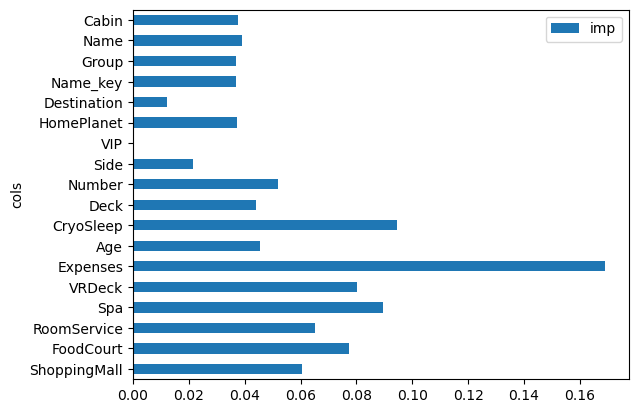

In [94]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf_model.feature_importances_)).plot('cols', 'imp', 'barh');

# Create Submission File

Here I'm converting the Transported column back into the True/False boolean values that will be needed for submission. 

In [35]:
test['Transported'] = xgb_model.predict(test)

In [36]:
passengerid

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01
...,...
4272,9266_02
4273,9269_01
4274,9271_01
4275,9273_01


In [37]:
test['PassengerId'] = passengerid.values

In [38]:
test

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,CryoSleep,Deck,Number,Side,VIP,HomePlanet,Destination,Name_key,Group,Name,Cabin,Transported,PassengerId
0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,1,3,3,1,0,1,0,6387,6217,8473,6561,1,0013_01
1,0.0,9.0,0.0,2823.0,0.0,2832.0,19.0,0,1,5,1,0,1,0,6388,6218,8474,6562,0,0018_01
2,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1,6,0,1,0,0,2,6389,6219,8475,6563,1,0019_01
3,0.0,6652.0,0.0,181.0,585.0,7418.0,38.0,0,6,1,1,0,0,0,6390,6220,8476,6564,1,0021_01
4,635.0,0.0,10.0,0.0,0.0,645.0,20.0,0,1,6,1,0,1,0,6391,6221,8477,6565,1,0023_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.0,0.0,0.0,0.0,0.0,0.0,34.0,1,3,1529,1,0,1,0,9531,9275,12624,9821,1,9266_02
4273,17.0,847.0,0.0,10.0,144.0,1018.0,42.0,0,1,4,1,0,1,0,9532,9276,12625,12,0,9269_01
4274,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1,5,361,0,0,2,2,9533,9277,12626,9822,1,9271_01
4275,0.0,2680.0,0.0,0.0,523.0,3203.0,18.0,0,5,287,0,0,0,0,9534,9278,12627,9823,1,9273_01


This creates the actual submission file with this initial benchmark random forest model. 

In [39]:
test['Transported'] = np.where(test['Transported'] == 1, 'True', 'False')

In [40]:
submit_file = test[['PassengerId', 'Transported']]

In [41]:
submit_file.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [42]:
submit_file.to_csv('submit_optimal_xgb_best_data.csv', index=False)

XGB with optimal model and best data received score of 0.80175. But only 0.79284 in the Kaggle submission. 